<a href="https://colab.research.google.com/github/MA-Sani/API-testing/blob/main/MRI_BoneCare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Navigate to Dataset Directory**

In [3]:
%cd /content/drive/MyDrive/BalDataSet/


/content/drive/MyDrive/BalDataSet


**Dataset Loading and Preprocessing**

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Image transformations
transform = transforms.Compose([
   transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
train_dir = "/content/drive/MyDrive/BalDataSet/Train"
val_dir = "/content/drive/MyDrive/BalDataSet/Val"
test_dir = "/content/drive/MyDrive/BalDataSet/Test"

train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True ,num_workers=2)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False , num_workers=2)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False , num_workers=2)

class_names = train_data.classes
print("Classes:", class_names)


Classes: ['Normal', 'Tumor']


**Model Initialization and Customization for Binary Classification**

In [24]:
import torchvision.models as models
import torch.nn as nn

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Load pre-trained ResNet model
model = models.resnet18(pretrained=True)

# Freeze base layers (optional for faster training)
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer for binary classification
model.fc = nn.Linear(model.fc.in_features, 2)

model = model.to(device)
print("Model is moved to:", next(model.parameters()).device)

Model is moved to: cpu


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
from collections import Counter
import os

train_dir = "/content/drive/MyDrive/BalDataSet/Train"
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}
print("📦 Training set class distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")


📦 Training set class distribution:
Normal: 2660
Tumor: 2660


# Model Training, Validation, and Metrics Saving

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import pickle
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# ---- Set device ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Define transforms ----
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # For RGB images
])

# ---- Dataset paths (set full path to your Google Drive directory) ----
base_dir = "/content/drive/MyDrive/BalDataSet"
train_path = os.path.join(base_dir, "Train")
val_path = os.path.join(base_dir, "Val")
test_path = os.path.join(base_dir, "Test")

# ---- Load datasets ----
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# ---- Create DataLoaders ----
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# ---- Define model ----
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Adjust to your number of classes
model = model.to(device)

# ---- Loss and optimizer ----
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---- Training settings ----
epochs = 20
best_val_acc = 0.0
train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []

# ---- Directory to save results ----
save_dir = os.path.join(base_dir, "saved_results")
os.makedirs(save_dir, exist_ok=True)

# ---- Training loop ----
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # ---- Validation ----
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(save_dir, "Best.pt"))

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# ---- Save training metrics ----
metrics = {
    "train_loss": train_loss_list,
    "train_acc": train_acc_list,
    "val_loss": val_loss_list,
    "val_acc": val_acc_list,
}
with open(os.path.join(save_dir, "training_metrics.pkl"), "wb") as f:
    pickle.dump(metrics, f)

print("✅ Training complete.")
print("📌 Best model saved to:", os.path.join(save_dir, "Best.pt"))
print("📊 Metrics saved to:", os.path.join(save_dir, "training_metrics.pkl"))


Epoch [1/20] Train Loss: 0.2714, Train Acc: 89.76% Val Loss: 0.1297, Val Acc: 95.13%
Epoch [2/20] Train Loss: 0.2031, Train Acc: 92.42% Val Loss: 0.1400, Val Acc: 92.63%
Epoch [3/20] Train Loss: 0.1611, Train Acc: 93.65% Val Loss: 0.1310, Val Acc: 96.32%
Epoch [4/20] Train Loss: 0.1279, Train Acc: 94.94% Val Loss: 0.1790, Val Acc: 92.76%
Epoch [5/20] Train Loss: 0.1095, Train Acc: 96.17% Val Loss: 0.0367, Val Acc: 98.55%
Epoch [6/20] Train Loss: 0.0925, Train Acc: 96.45% Val Loss: 0.2006, Val Acc: 90.92%
Epoch [7/20] Train Loss: 0.0914, Train Acc: 96.86% Val Loss: 0.0385, Val Acc: 98.68%
Epoch [8/20] Train Loss: 0.0790, Train Acc: 97.05% Val Loss: 0.0845, Val Acc: 97.63%
Epoch [9/20] Train Loss: 0.0523, Train Acc: 98.18% Val Loss: 0.1881, Val Acc: 91.97%
Epoch [10/20] Train Loss: 0.0538, Train Acc: 97.95% Val Loss: 0.0625, Val Acc: 97.37%
Epoch [11/20] Train Loss: 0.0484, Train Acc: 98.31% Val Loss: 0.0694, Val Acc: 96.58%
Epoch [12/20] Train Loss: 0.0325, Train Acc: 98.76% Val Loss: 0

**Model Evaluation on Test Dataset**

In [34]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model architecture
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(in_features=512, out_features=2)  # For binary classification
model = model.to(device)

# Load trained weights
save_path = "/content/drive/MyDrive/BalDataSet/saved_results/Best.pt"
model.load_state_dict(torch.load(save_path, map_location=device))
model.eval()

# Define transforms (must match training time)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load test dataset
test_data_path = "/content/drive/MyDrive/BalDataSet/Test"
test_dataset = datasets.ImageFolder(root=test_data_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"\n Accuracy: {accuracy:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



 Accuracy: 98.68%


**Load Model and Setup**

In [25]:
import torch
import torch.nn as nn
from torchvision import models
import os
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 2)  # For binary classification
model = model.to(device)

# Load saved weights
model.load_state_dict(torch.load("/content/drive/MyDrive/BalDataSet/saved_results/Best.pt", map_location=device))
model.eval()

# Clear output (works in Jupyter/Colab)
from IPython.display import clear_output
clear_output(wait=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Load Test Data

In [26]:
from torchvision import transforms

# Test transforms
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load dataset
test_dataset = datasets.ImageFolder("/content/drive/MyDrive/BalDataSet/Test", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# **Generate Predictions**

In [27]:
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = []
y_prob = []  # probabilities for ROC/PR curve

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # get probability for class "Tumor"
        y_true.extend(labels.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())


# **Confusion Matrix**

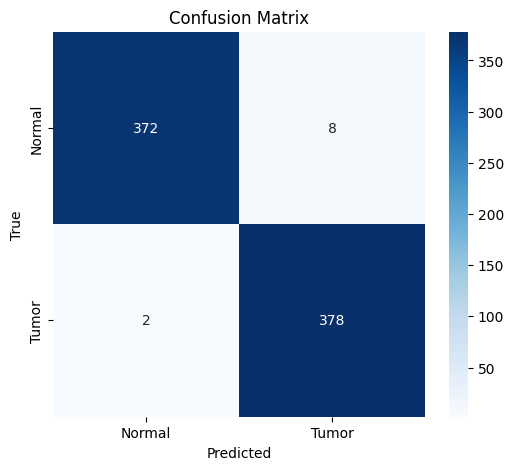

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Tumor'], yticklabels=['Normal', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# **Classification Report**

In [8]:
from sklearn.metrics import classification_report

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Tumor']))



📊 Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99       380
       Tumor       0.98      0.99      0.99       380

    accuracy                           0.99       760
   macro avg       0.99      0.99      0.99       760
weighted avg       0.99      0.99      0.99       760



**Training & Validation Graphs (load metrics)bold text**

In [9]:
import pickle

metrics_path = "/content/drive/MyDrive/BalDataSet/saved_results/training_metrics.pkl"

with open(metrics_path, 'rb') as f:
    metrics = pickle.load(f)

train_loss = metrics.get("train_loss", [])
val_loss = metrics.get("val_loss", [])
train_acc = metrics.get("train_acc", [])
val_acc = metrics.get("val_acc", [])
epochs = range(1, len(train_loss) + 1)


# **Plot: Train Loss**

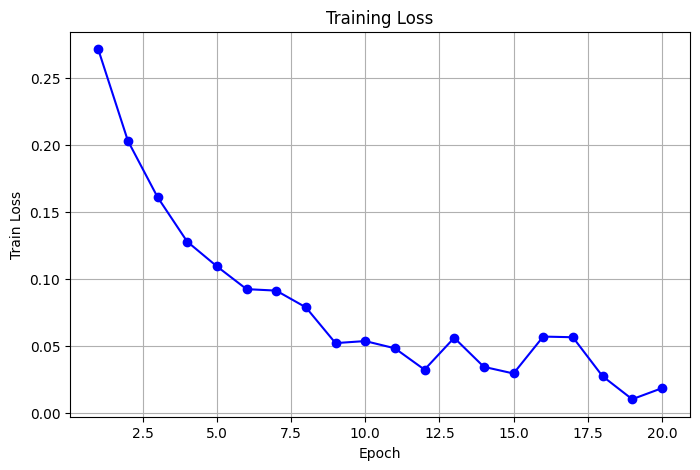

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, color='blue', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()


# **Plot: Validation Loss**

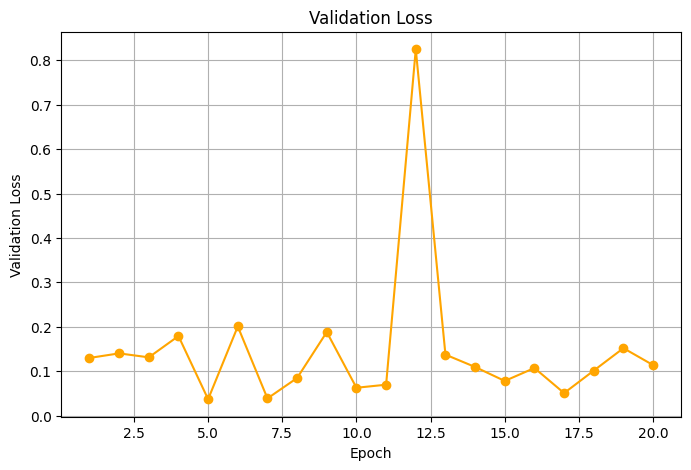

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, val_loss, color='orange', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss")
plt.grid(True)
plt.show()


# **Plot: Train Accuracy**

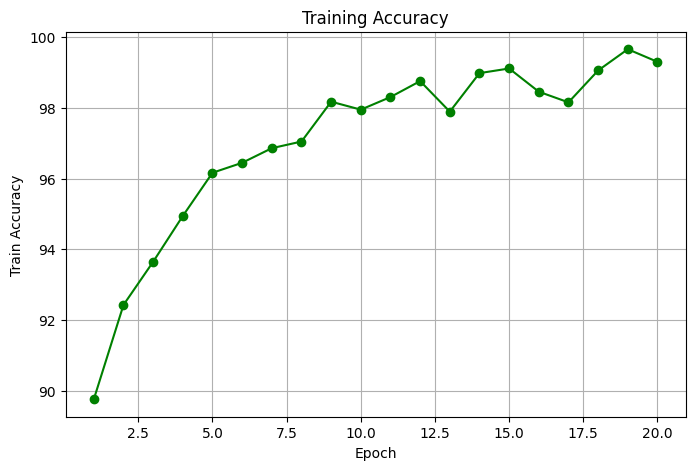

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc, color='green', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Train Accuracy")
plt.title("Training Accuracy")
plt.grid(True)
plt.show()


# **Plot: Validation Accuracy**

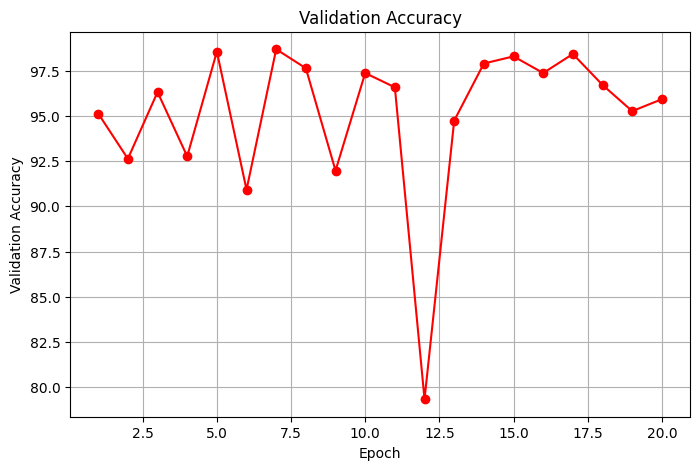

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, val_acc, color='red', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy")
plt.grid(True)
plt.show()


# **Plot Precision-Recall Curve**

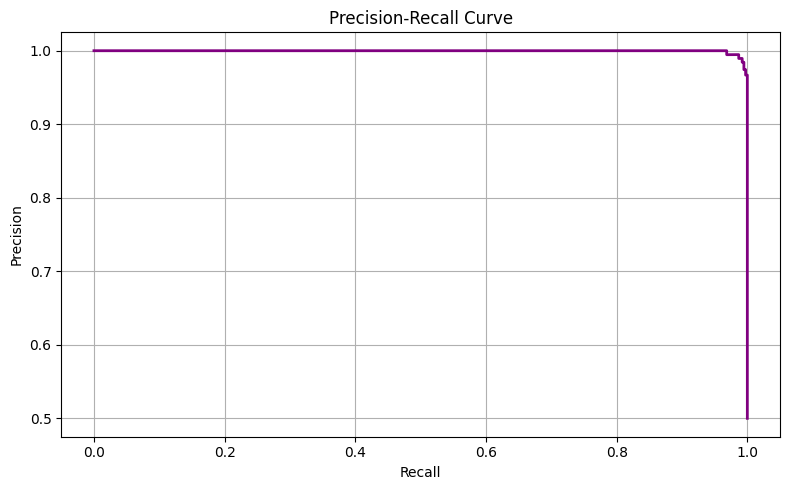

In [14]:
precision, recall, _ = precision_recall_curve(y_true, y_prob)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/precision_recall_curve.png")
plt.show()


# **Plot ROC Curve**

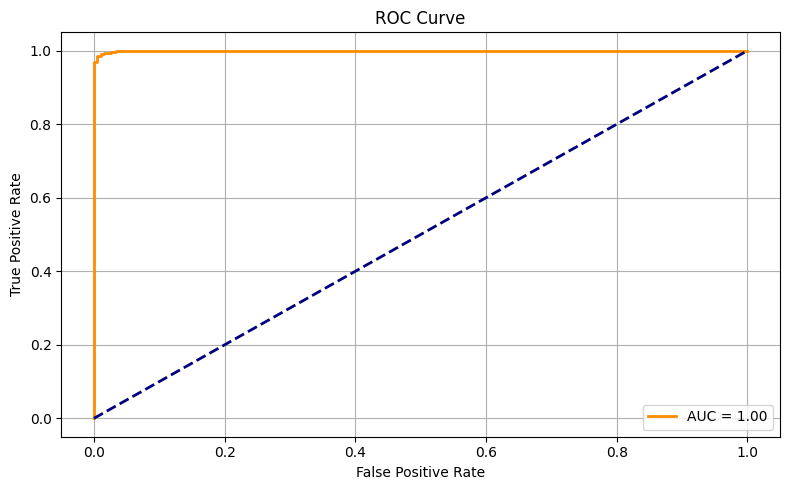

In [15]:
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# **Showing Segment Outputs**

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[0] ✅ Predicted: Tumor | 🎯 Actual: Tumor


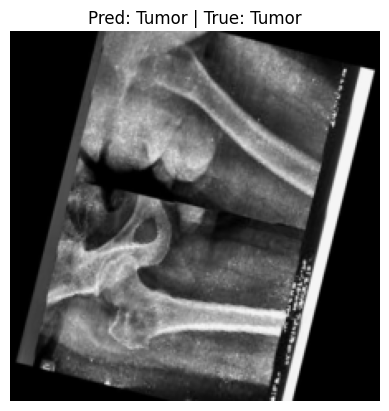

[1] ✅ Predicted: Normal | 🎯 Actual: Normal


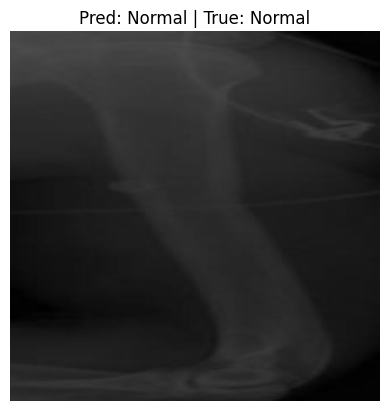

[2] ✅ Predicted: Normal | 🎯 Actual: Normal


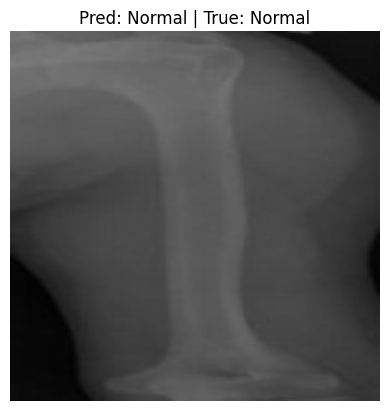

[3] ✅ Predicted: Tumor | 🎯 Actual: Tumor


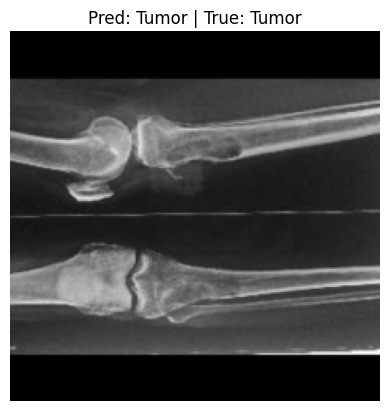

[4] ✅ Predicted: Tumor | 🎯 Actual: Tumor


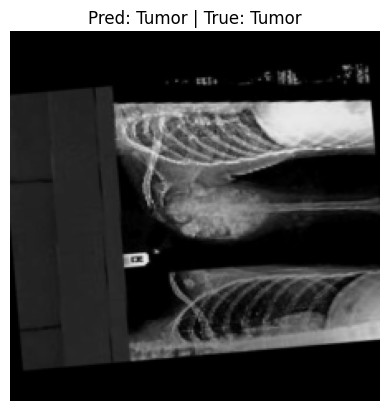

[5] ✅ Predicted: Tumor | 🎯 Actual: Tumor


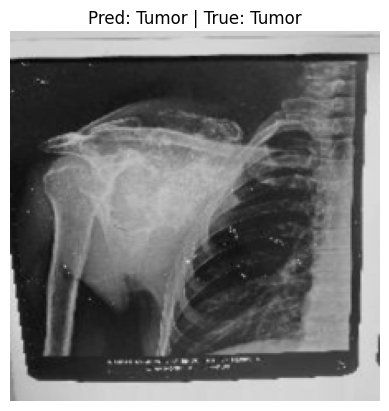

[6] ✅ Predicted: Normal | 🎯 Actual: Normal


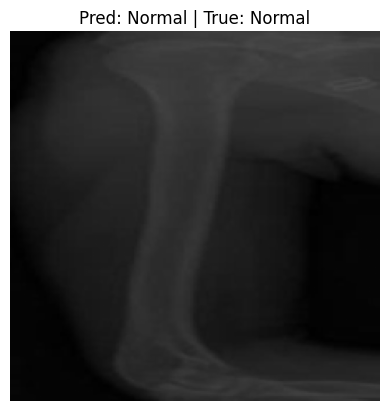

[7] ✅ Predicted: Tumor | 🎯 Actual: Tumor


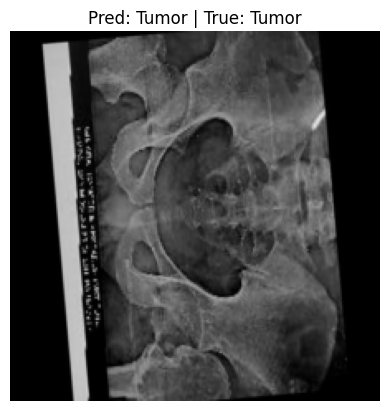

[8] ✅ Predicted: Normal | 🎯 Actual: Normal


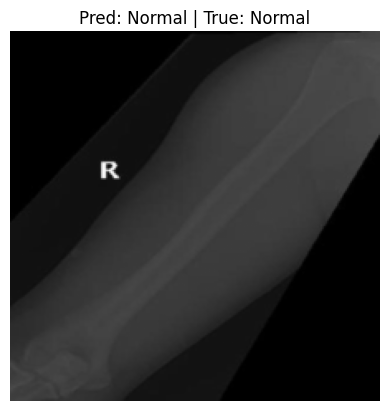

[9] ✅ Predicted: Normal | 🎯 Actual: Normal


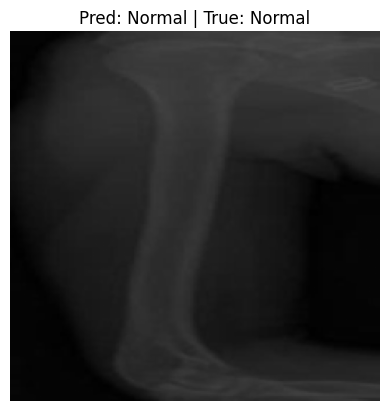


📊 Images shown per class:
Normal: 5
Tumor: 5


In [16]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Unnormalize and show image
def imshow(img, title=None):
    img = img * 0.5 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define test transforms
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load test dataset
test_path = "/content/drive/MyDrive/BalDataSet/Test"
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)  # Shuffle to randomize class order

# Initialize model and load weights
model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=False)
model.fc = torch.nn.Linear(512, 2)
model.load_state_dict(torch.load("/content/drive/MyDrive/BalDataSet/saved_results/Best.pt", map_location=device))
model = model.to(device)
model.eval()

# Counters
shown_per_class = {cls: 0 for cls in test_dataset.classes}
min_to_show = 5
max_to_show = 8

# Prediction loop
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for j in range(images.size(0)):
            pred_class = test_dataset.classes[preds[j].item()]
            true_class = test_dataset.classes[labels[j].item()]

            # Show image if this class hasn't hit the limit
            if shown_per_class[pred_class] < max_to_show:
                print(f"[{i * images.size(0) + j}] ✅ Predicted: {pred_class} | 🎯 Actual: {true_class}")
                imshow(images[j].cpu(), f"Pred: {pred_class} | True: {true_class}")
                shown_per_class[pred_class] += 1

            # If both classes have enough shown, break
            if all(min_to_show <= count <= max_to_show for count in shown_per_class.values()):
                break
        else:
            continue
        break

# Summary
print("\n📊 Images shown per class:")
for cls, count in shown_per_class.items():
    print(f"{cls}: {count}")


# ***Detecting , Classifying & Segementing Bone MRI: Normal vs Tumor (Upload & Predict)***

Saving hand_0_2_png.rf.e751054e0d8b7e77993ab1f22ae58433.jpg to hand_0_2_png.rf.e751054e0d8b7e77993ab1f22ae58433.jpg


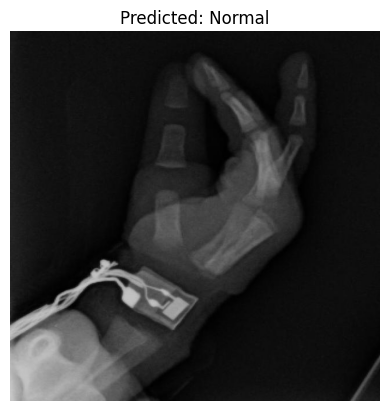

In [7]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

# 📍 Upload image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# 📦 Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🧠 Load model architecture
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 2)  # 2 classes: Normal, Tumor
model.load_state_dict(torch.load("/content/drive/MyDrive/BalDataSet/saved_results/Best.pt", map_location=device))
model = model.to(device)
model.eval()

# 🔄 Preprocessing same as training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# 📸 Load and preprocess image
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# 🔍 Predict
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)
    class_names = ['Normal', 'Tumor']
    prediction = class_names[predicted.item()]

# 🎯 Show result
plt.imshow(image)
plt.title(f"Predicted: {prediction}")
plt.axis('off')
plt.show()


Saving 1_JPG_jpg.rf.6c158cba50ec8c9cafda95efb7bc3441.jpg to 1_JPG_jpg.rf.6c158cba50ec8c9cafda95efb7bc3441.jpg


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


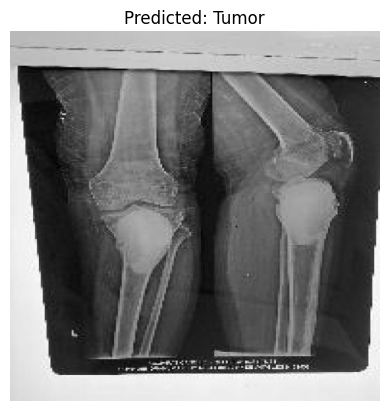

In [5]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

# 📍 Upload image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# 📦 Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🧠 Load model architecture
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 2)  # 2 classes: Normal, Tumor
model.load_state_dict(torch.load("/content/drive/MyDrive/BalDataSet/saved_results/Best.pt", map_location=device))
model = model.to(device)
model.eval()

# 🔄 Preprocessing same as training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# 📸 Load and preprocess image
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# 🔍 Predict
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)
    class_names = ['Normal', 'Tumor']
    prediction = class_names[predicted.item()]

# 🎯 Show result
plt.imshow(image)
plt.title(f"Predicted: {prediction}")
plt.axis('off')
plt.show()
